When machine learning algorithms are trained on data that has been labeled, in order to predict the labels for data that has not, they're called "supervised learning" algorithms; on the other hand, when they search for patterns in unlabeled data, in order to simplify it, they're called "unsupervised learning" algorithms. How might unsupervised learning algorithms, such as Isomap and K-means, categorize D&D monsters according to their stats alone? For example,  it group dragons together?

Let's have a look at the data:

In [1]:
import pandas as pd

data = pd.read_json('srd_5e_monsters.json')
data.head()

,name,meta,Armor Class,Hit Points,Speed,STR,STR_mod,DEX,DEX_mod,CON,...,Challenge,Traits,Actions,Legendary Actions,img_url,Damage Immunities,Condition Immunities,Damage Resistances,Damage Vulnerabilities,Reactions
0,Aboleth,"Large aberration, lawful evil",17 (Natural Armor),135 (18d10 + 36),"10 ft., swim 40 ft.",21,(+5),9,(-1),15,...,"10 (5,900 XP)",<p><em><strong>Amphibious.</strong></em> The a...,<p><em><strong>Multiattack.</strong></em> The ...,"<p>The aboleth can take 3 legendary actions, c...",https://media-waterdeep.cursecdn.com/avatars/t...,NaN,NaN,NaN,NaN,NaN
1,Acolyte,"Medium humanoid, any",10,9 (2d8),30 ft.,10,(+0),10,(+0),10,...,1/4 (50 XP),<p><em><strong>Spellcasting.</strong></em> The...,<p><em><strong>Club.</strong></em> <em>Melee W...,NaN,https://media-waterdeep.cursecdn.com/attachmen...,NaN,NaN,NaN,NaN,NaN
2,Adult Black Dragon,"Huge dragon, chaotic evil",19 (Natural Armor),195 (17d12 + 85),"40 ft., fly 80 ft., swim 40 ft.",23,(+6),14,(+2),21,...,"14 (11,500 XP)",<p><em><strong>Amphibious.</strong></em> The d...,<p><em><strong>Multiattack.</strong></em> The ...,"<p>The dragon can take 3 legendary actions, ch...",https://media-waterdeep.cursecdn.com/avatars/t...,Acid,NaN,NaN,NaN,NaN
3,Adult Blue Dragon,"Huge dragon, lawful evil",19 (Natural Armor),225 (18d12 + 108),"40 ft., burrow 30 ft., fly 80 ft.",25,(+7),10,(+0),23,...,"16 (15,000 XP)",<p><em><strong>Legendary Resistance (3/Day).</...,<p><em><strong>Multiattack.</strong></em> The ...,"<p>The dragon can take 3 legendary actions, ch...",https://media-waterdeep.cursecdn.com/avatars/t...,Lightning,NaN,NaN,NaN,NaN
4,Adult Brass Dragon,"Huge dragon, chaotic good",18 (Natural Armor),172 (15d12 + 75),"40 ft., burrow 30 ft., fly 80 ft.",23,(+6),10,(+0),21,...,"13 (10,000 XP)",<p><em><strong>Legendary Resistance (3/Day).</...,<p><em><strong>Multiattack.</strong></em> The ...,"<p>The dragon can take 3 legendary actions, ch...",https://media-waterdeep.cursecdn.com/avatars/t...,Fire,NaN,NaN,NaN,NaN


There's a lot of information here, and it will need to be converted into fully numerical form before PCA and K-means can act on it. Also, there's a columns that includes urls for images of nearly all of the monsters; we'd like to use those in presenting our results. I've already run a script that downloads those images and turns them into thumbnails, so we just need to clean the data. 

We start by eliminating the rows for monsters that don't have corresponding images as well as columns that have NaN values, and creating a separate column to keep track of the row numbers identifying each monster. (The image files have these same numbers as suffixes, and it will be important to keep track of which row goes with which image file.)

In [2]:
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer

data['monster num'] = data.index
rows_to_keep = pd.read_csv('rows_to_keep.csv')
data = data.iloc[rows_to_keep['keep']]
data = data.dropna(axis=1).reset_index(drop=True)
data = data.drop('img_url',axis=1)

Next we clean up the columns with numerical data (e.g., for the modifiers we need to have entries like "1" and not "(+1)") and vectorize the columns with linguistic data.

In [3]:
for i in range(data.shape[0]):
    data.loc[i,'Hit Points'] =int(re.search(r"(\d+)", \
                              data.loc[i]['Hit Points']).group())
    data.loc[i,'Challenge']  =int(re.search(r"(\d+)", \
                              data.loc[i]['Challenge']).group())
    data.loc[i,'Armor Class']=int(re.search(r"(\d+)", \
                              data.loc[i]['Armor Class']).group())
    data.loc[i,'Speed']      =int(re.search(r"(\d+)", \
                              data.loc[i]['Speed']).group())
    data.loc[i,'STR_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['STR_mod']).group())
    data.loc[i,'DEX_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['DEX_mod']).group())
    data.loc[i,'CON_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['CON_mod']).group())
    data.loc[i,'CHA_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['CHA_mod']).group())
    data.loc[i,'INT_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['INT_mod']).group())
    data.loc[i,'WIS_mod']    =int(re.search(r"(\d+)", \
                              data.loc[i]['WIS_mod']).group())

vec = CountVectorizer()
langs = vec.fit_transform(data['Languages'])
langs = pd.DataFrame(langs.toarray(), \
                     columns=vec.get_feature_names_out())
data = data.drop(['Languages'],axis=1)

meta = vec.fit_transform(data['meta'])
meta = pd.DataFrame(meta.toarray(), \
                    columns=vec.get_feature_names_out())
data = data.drop(['meta'],axis=1)

senses = vec.fit_transform(data['Senses'])
senses = pd.DataFrame(senses.toarray(), \
                      columns=vec.get_feature_names_out())
data = data.drop(['Senses'],axis=1)

data = pd.concat((data,langs,meta,senses),axis=1)

Now that the data is cleaned, we store the monster number and name is a separate data frame and drop the "Challenge" column because we don't want the monster challenge rating to dominate the resulting categorization. Next, we rescale the data so that, e.g., hit points don't dominate simply because they are on a larger numerical scale than the other attributes.

In [4]:
from sklearn.preprocessing import StandardScaler

X = data.drop(['name','monster num','Challenge'],axis=1)
names = data[['name','monster num']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

Now we can apply Isomap to reduce the dimensionality of the space before applying K-means.

In [5]:
from sklearn.manifold import Isomap
from sklearn.cluster import SpectralClustering

model = Isomap(n_neighbors=7)
model.fit(X)

X_iso = pd.DataFrame(model.fit_transform(X),index=data.index)
X_iso['monster num'] = data['monster num']
X_iso = X_iso.set_index('monster num')

kmeans = SpectralClustering(n_clusters=5, \
                            affinity='nearest_neighbors',
                            assign_labels='kmeans')
kmeans.fit(X_iso)
labels = kmeans.fit_predict(X_iso)

We have re-indexed X_iso above by monster number for plotting the results, with which we now proceed.

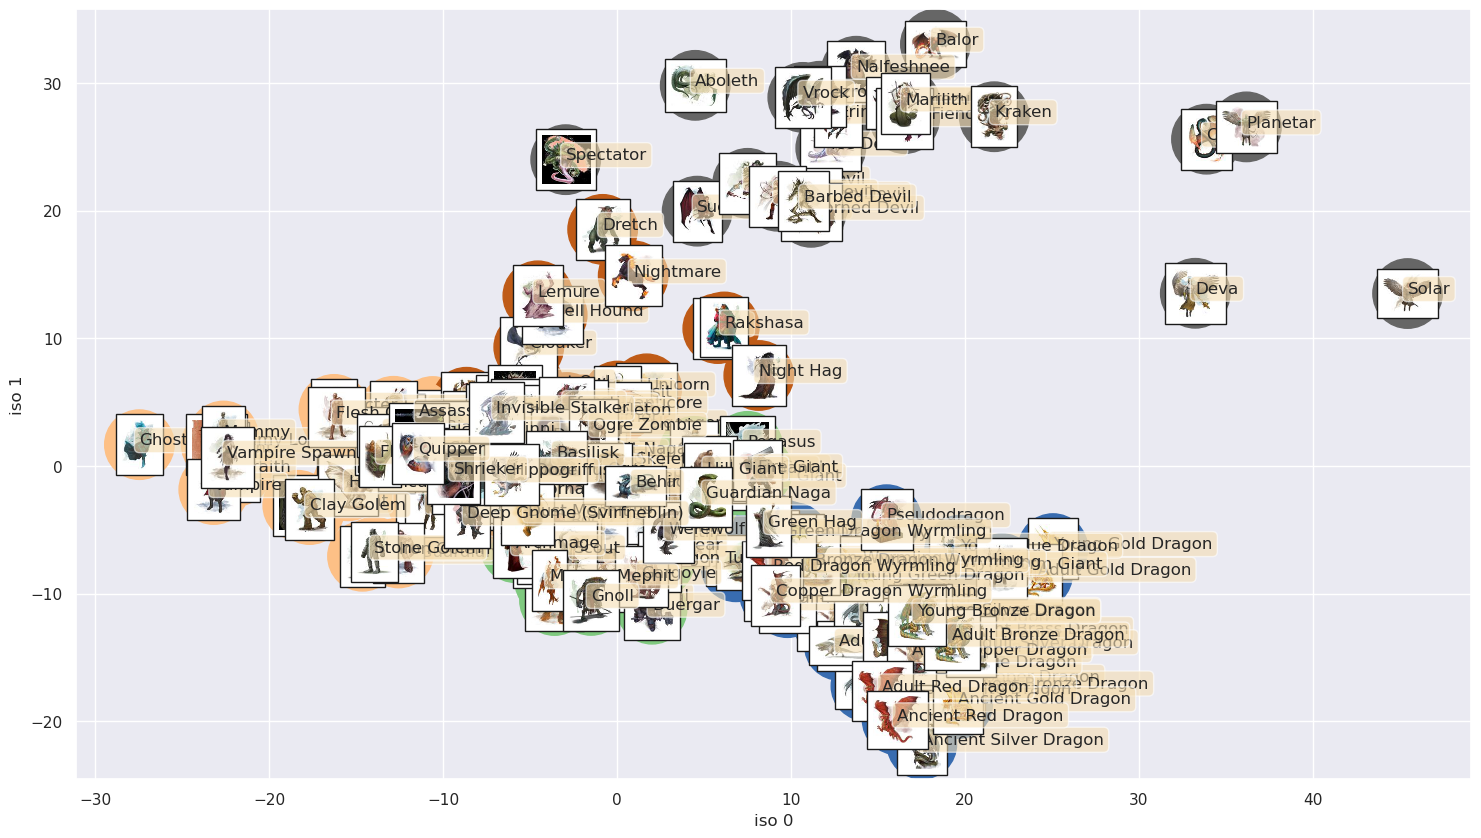

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import offsetbox
from PIL import Image
import os

%matplotlib inline

iso_x = 0
iso_y = 1
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
im = ax.scatter(X_iso.loc[:][iso_x],X_iso.loc[:][iso_y],s=2500, \
                c=labels,cmap='Accent')
#fig.colorbar(im)

# load the monster images and plot them on top of the data
# points
directory = './monster_img'

pics = []
file_nums = np.arange(400)
for filename in os.listdir(directory):
    # strip the number off the file name
    img_id = re.search(r"(\d+)", filename).group()
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        pics.append([int(img_id),Image.open(f)])
images = pd.DataFrame(pics,columns=['monster num','jpeg'])
images = images.join(names.set_index('monster num'),on='monster num')
names = images['name']

def plot_components(X_iso, images, ax):
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
    for i in range(images.shape[0]):
        num = images['monster num'][i]
        coords = [X_iso.loc[num][iso_x],X_iso.loc[num][iso_y]]
        imagebox = offsetbox.AnnotationBbox( \
            offsetbox.OffsetImage( \
            images.set_index('monster num').loc[num][0], \
            cmap='gray', \
            zoom=0.35),coords)
        ax.add_artist(imagebox)
        ax.text(X_iso.loc[num][iso_x],X_iso.loc[num][iso_y], \
                names[i], \
                bbox=props)
    ax.set_xlabel('iso '+str(iso_x))
    ax.set_ylabel('iso '+str(iso_y))

plot_components(X_iso,images,ax)

The circles underlying the thumbnail images have been color-labeled and sorted into 5 groups via K-means; we see that, e.g., the dragons have indeed been placed together, as have mostly the undead and the celestials. Isomap and K-means have done a decent job of collecting like monsters with like, with knowledge only of the stats and not including the challenge rating.